### Testing Evo

#### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch_geometric
from torch_geometric.nn import GCNConv
import IPython
from IPython.display import display, HTML, Image
from torch_geometric.loader import DataLoader

from graphUtils import add_edges
from generator import generate_organism
from cell import Cell
from organism import Organism
from GNCAmodel import GNCA
from visualizer import Visualizer
from evo_trainer import Evo_Trainer

#%run Visualizer.py # --allows for reloading the particular code
%run CGConv.py

#### Train the network

In [2]:
n = 1
popsize = 10
generations = 500
batch_size = 8
wrap_around = True
name = 'centered8'
#device = torch.device('mps')
device = torch.device('cpu')
trainer = Evo_Trainer(n, device, batch_size, True, popsize)

2023-03-01 18:09:11,737	INFO worker.py:1528 -- Started a local Ray instance.


[2023-03-01 18:09:14] INFO     < 4414> evotorch.core: Instance of `Custom_NEProblem` (id:11274460544) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-03-01 18:09:14] INFO     < 4414> evotorch.core: Instance of `Custom_NEProblem` (id:11274460544) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-03-01 18:09:14] INFO     < 4414> evotorch.core: Instance of `Custom_NEProblem` (id:11274460544) -- The `device` of the problem is set as cpu
[2023-03-01 18:09:14] INFO     < 4414> evotorch.core: Instance of `Custom_NEProblem` (id:11274460544) -- The number of actors that will be allocated for parallelized evaluation is 10
[2023-03-01 18:09:14] INFO     < 4414> evotorch.core: Instance of `Custom_NEProblem` (id:11274460544) -- Number of GPUs that will be allocated per actor is None


In [3]:
trainer.train(generations, name)

              iter : 1
    obj0_mean_eval : 1.5750000476837158
obj0_pop_best_eval : 3.125
  obj0_median_eval : 1.25
    obj1_mean_eval : 1.3895328044891357
obj1_pop_best_eval : 1.1420629024505615
  obj1_median_eval : 1.3580987453460693
    obj2_mean_eval : 450.2911682128906
obj2_pop_best_eval : 584.3243408203125
  obj2_median_eval : 432.84210205078125
    obj3_mean_eval : 32.890865325927734
obj3_pop_best_eval : 19.34739112854004
  obj3_median_eval : 33.6247673034668

              iter : 2
    obj0_mean_eval : 1.8125
obj0_pop_best_eval : 2.75
  obj0_median_eval : 1.75
    obj1_mean_eval : 1.473570704460144
obj1_pop_best_eval : 1.1182470321655273
  obj1_median_eval : 1.4298549890518188
    obj2_mean_eval : 475.72802734375
obj2_pop_best_eval : 633.0958862304688
  obj2_median_eval : 471.8873291015625
    obj3_mean_eval : 32.54782485961914
obj3_pop_best_eval : 23.586833953857422
  obj3_median_eval : 30.62884521484375

              iter : 3
    obj0_mean_eval : 1.625
obj0_pop_best_eval : 2

In [4]:
network = trainer.get_trained_network()

In [6]:
#network = trainer.problem.parameterize_net(trainer.searcher.status['best'][0])
#network = trainer.problem.parameterize_net(trainer.searcher.status['center'][0])
network = trainer.problem.parameterize_net(trainer.searcher.status['obj0_pop_best'])
#network = trainer.problem.parameterize_net(trainer.searcher.status['obj4_pop_best'])

In [7]:
#trainer.searcher.status

#### Visualize trained network

In [8]:
graphs = [generate_organism(n, device).toGraph() for _ in range(1)]
loader = DataLoader(graphs, batch_size=2)
graph = next(iter(loader))
visualizer = Visualizer(wrap_around)
network.batch_size = 1
network(graph, 0)

DataBatch(x=[21, 5], edge_index=[1, 0], device=[1], subsize=[1], energy=[1], velocity=[1], border_cost=[1], food_reward=[1], dead_cost=[1], visible_food=[1], food_avg_dist=[1], food_avg_degree=[1], batch=[21], ptr=[2])

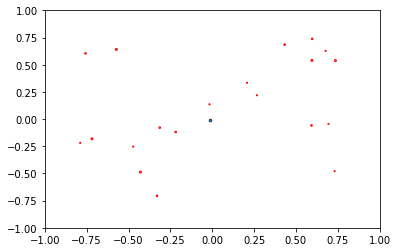

In [9]:
anim = visualizer.animate_organism(graph, network, food=30, frames=200)
visualizer.save_animation_to_gif(anim, name, 10)

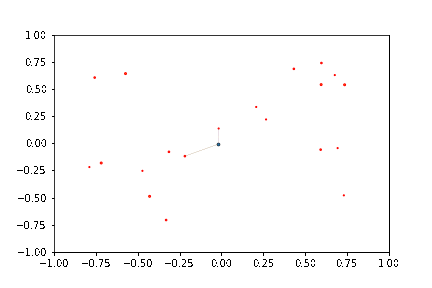

In [10]:
Image('../animation/' + name + '.gif')

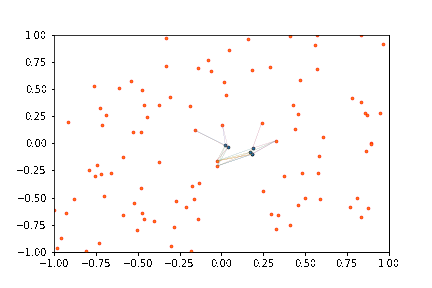

In [11]:
Image('../animation/GATConv1.gif')

In [12]:
anim.frame_seq = anim.new_saved_frame_seq() 
IPython.display.HTML(anim.to_jshtml())

In [13]:
print(network)

CGConv1(
  (conv_layer_cells): CGConv(4, dim=4)
  (conv_layer_food): CGConv(4, dim=4)
  (mlp_before): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Tanh()
  )
  (mlp_middle): Sequential(
    (0): Tanh()
    (1): Linear(in_features=8, out_features=4, bias=True)
    (2): Tanh()
  )
  (mlp): Sequential(
    (0): Tanh()
    (1): Linear(in_features=4, out_features=2, bias=True)
    (2): Tanh()
  )
  (gConvGRU): GConvGRU(
    (conv_x_z): ChebConv(4, 4, K=1, normalization=sym)
    (conv_h_z): ChebConv(4, 4, K=1, normalization=sym)
    (conv_x_r): ChebConv(4, 4, K=1, normalization=sym)
    (conv_h_r): ChebConv(4, 4, K=1, normalization=sym)
    (conv_x_h): ChebConv(4, 4, K=1, normalization=sym)
    (conv_h_h): ChebConv(4, 4, K=1, normalization=sym)
  )
)


In [14]:
print('conv_layers1: ', network.conv_layer_cells)
for param in network.conv_layer_cells.parameters():
  print(param.data)

print('conv_layers2: ', network.conv_layer_food)
for param in network.conv_layer_food.parameters():
  print(param.data)

conv_layers1:  CGConv(4, dim=4)
tensor([[-1.1933e-04, -2.6865e-01,  5.4654e-01,  2.2779e-01,  3.0252e-01,
         -2.7083e-01, -1.0471e+00, -3.4949e-02, -1.4196e-01, -3.0678e-01,
         -8.1209e-02, -5.7577e-02],
        [-3.0090e-01, -2.6219e-01,  5.9452e-01, -5.1325e-01,  8.0114e-01,
          1.9270e-01,  5.9276e-02, -2.3273e-01, -4.5596e-01, -1.0377e-01,
         -1.1967e-01,  1.5818e-01],
        [ 4.8514e-01,  4.6056e-01, -2.8324e-01, -7.2677e-02, -6.4849e-02,
         -6.0241e-02, -1.2821e-01,  6.7079e-01,  1.6696e-02,  2.1635e-01,
          2.6587e-01,  4.0603e-01],
        [-6.6471e-02,  1.6371e-01,  3.6689e-01,  3.1956e-01,  2.5621e-01,
         -7.9043e-02, -4.1451e-01,  8.1239e-01, -7.0531e-02,  6.6943e-01,
         -1.6015e-01, -3.0549e-01]])
tensor([ 0.3977,  0.0328, -0.6354, -0.1666])
tensor([[ 0.2577,  0.1614,  0.2368, -0.0689,  0.5683,  0.0740,  0.1065,  0.0294,
         -0.4455, -0.2600,  0.2127,  0.4107],
        [ 0.2856,  0.0542, -0.7223, -0.2437, -0.1728,  0.21

In [15]:
print('GConvGRU: ', network.gConvGRU)
for param in network.gConvGRU.parameters():
  print(param.data)


GConvGRU:  GConvGRU(
  (conv_x_z): ChebConv(4, 4, K=1, normalization=sym)
  (conv_h_z): ChebConv(4, 4, K=1, normalization=sym)
  (conv_x_r): ChebConv(4, 4, K=1, normalization=sym)
  (conv_h_r): ChebConv(4, 4, K=1, normalization=sym)
  (conv_x_h): ChebConv(4, 4, K=1, normalization=sym)
  (conv_h_h): ChebConv(4, 4, K=1, normalization=sym)
)
tensor([-0.0139, -0.3424,  0.1712,  0.6106])
tensor([[-0.2385, -0.1497,  0.0032, -0.0294],
        [ 0.4766,  0.0745, -0.2726,  0.0571],
        [-0.0500,  0.3790, -0.7657,  0.4001],
        [ 0.2767, -0.2947, -0.7192,  0.2676]])
tensor([-0.3435,  0.0848, -0.0836, -0.0549])
tensor([[ 0.3506,  0.0378, -0.8950, -0.3497],
        [-0.0504,  0.2293,  0.5981,  0.1526],
        [ 0.1692,  0.6849,  0.3461, -0.0702],
        [-0.2711, -0.2177,  0.4402, -0.2396]])
tensor([-0.0756,  0.2776, -0.3858,  0.1403])
tensor([[-0.2938,  0.8186,  0.2628,  0.8289],
        [-0.2402, -0.2024,  0.0636,  0.1741],
        [-0.1255,  0.4808, -0.0148,  0.3384],
        [ 0.1495

In [16]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

#### Visualization of loss:

In [17]:
import matplotlib.pyplot as plt
losses = trainer.logger_df
print(losses)
plt.plot(losses.stepsize)

plt.plot(losses.median_eval)
plt.plot(losses.pop_best_eval)
plt.plot(losses.mean_eval)
#plt.legend(('median_eval', 'pop_best_eval', 'mean eval'))
plt.show()

      obj0_mean_eval  obj0_pop_best_eval  obj0_median_eval  obj1_mean_eval  \
iter                                                                         
1             1.5750               3.125             1.250        1.389533   
2             1.8125               2.750             1.750        1.473571   
3             1.6250               2.375             1.750        1.303825   
4             1.4375               1.875             1.625        1.264379   
5             1.3375               1.750             1.250        1.119843   
...              ...                 ...               ...             ...   
496           2.0500               2.500             1.875        0.819890   
497           2.2500               3.500             2.000        1.121415   
498           4.5125               6.125             4.500        0.947500   
499           3.2000               4.000             3.125        0.961181   
500           1.8625               2.750             1.875      

AttributeError: 'DataFrame' object has no attribute 'stepsize'

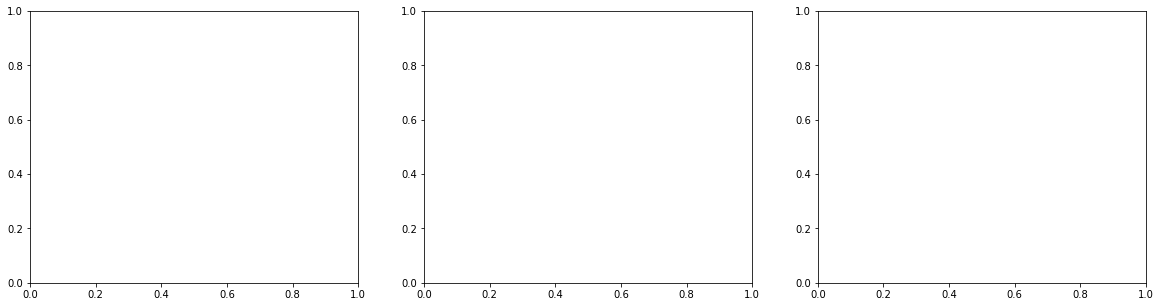

In [ ]:
trainer.logger_df
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.suptitle('')
plt.show()